In [1]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json
from ms_deisotope import deconvolute_peaks, averagine, scoring
from ms_deisotope.deconvolution import peak_retention_strategy
from os.path import expanduser
import peakutils

In [2]:
# include points from either side of the intense point
MS1_PEAK_DELTA = 0.1

In [3]:
experiment_base_dir = '/media/big-ssd/experiments'
experiment_name = 'P3856'
feature_detection_method = 'pasef'
run_name = 'P3856_YHE211_1_Slot1-1_1_5104'
EXPERIMENT_DIR = "{}/{}".format(experiment_base_dir, experiment_name)

In [4]:
# select a precursor cuboid id to visualise
d = pd.read_pickle('{}/features-pasef-backup/exp-{}-run-{}-features-pasef-dedup.pkl'.format(EXPERIMENT_DIR, experiment_name, run_name))
idents_df = d['features_df']

In [5]:
# precursor_cuboid_id = idents_df.sample(n=1).iloc[0].precursor_cuboid_id
# precursor_cuboid_id

# some good precursors for analysis
precursor_cuboid_id = 23911
# precursor_cuboid_id = 18601

#### generate the visualisation file

python -u ./otf-peak-detect/pipeline/detect-features.py -eb /media/big-ssd/experiments -en P3856 -rn P3856_YHE211_1_Slot1-1_1_5104 -rm local -pdm pasef -pid 12412

In [6]:
VIS_FILE = '{}/feature-detection-visualisation-{}.pkl'.format(expanduser("~"), precursor_cuboid_id)

In [7]:
# load the visualisation file for this precursor cuboid
vis_d = pd.read_pickle(VIS_FILE)
vis_d.keys()

dict_keys(['precursor_cuboid_d', 'wide_ms1_points_df', 'peaks_after_intensity_descent', 'deconvolution_features_df', 'features_df'])

In [8]:
before_df = vis_d['wide_ms1_points_df']
before_df['normalised_intensity'] = before_df.intensity / before_df.intensity.max()
metadata_d = vis_d['precursor_cuboid_d']

In [9]:
metadata_d.keys()

dict_keys(['precursor_cuboid_id', 'mz_lower', 'mz_upper', 'wide_mz_lower', 'wide_mz_upper', 'scan_lower', 'scan_upper', 'wide_scan_lower', 'wide_scan_upper', 'ms1_rt_lower', 'ms1_rt_upper', 'wide_ms1_rt_lower', 'wide_ms1_rt_upper', 'ms2_rt_lower', 'ms2_rt_upper'])

In [10]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

# Rescale to values between 0 and 1
tableau20_mpl = tableau20.copy()
for i in range(len(tableau20_mpl)):  
    r, g, b = tableau20_mpl[i]  
    tableau20_mpl[i] = (r / 255., g / 255., b / 255.)

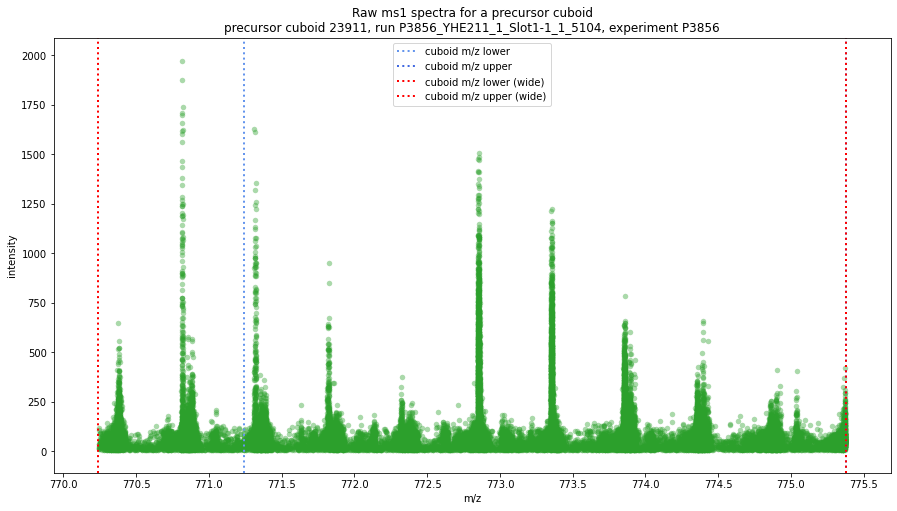

In [11]:
f, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

ax.scatter(before_df.mz, before_df.intensity, marker='o', color='tab:green', lw=0, s=30, alpha=0.4)

plt.xlabel('m/z')
plt.ylabel('intensity')
f.set_figheight(8)
f.set_figwidth(15)

nearest = 0.5
range_l = round(before_df.mz.min() / nearest) * nearest
range_u = round(before_df.mz.max() / nearest) * nearest
plt.xticks(np.arange(range_l,range_u+nearest,nearest))

plt.axvline(x=metadata_d['mz_lower'], linestyle=':', color='cornflowerblue', linewidth=2, label='cuboid m/z lower')
plt.axvline(x=metadata_d['mz_upper'], linestyle=':', color='royalblue', linewidth=2, label='cuboid m/z upper')

plt.axvline(x=metadata_d['wide_mz_lower'], linestyle=':', color='red', linewidth=2, label='cuboid m/z lower (wide)')
plt.axvline(x=metadata_d['wide_mz_upper'], linestyle=':', color='red', linewidth=2, label='cuboid m/z upper (wide)')

plt.margins(0.06)
plt.legend(loc='best')
plt.title('Raw ms1 spectra for a precursor cuboid\nprecursor cuboid {}, run {}, experiment {}'.format(precursor_cuboid_id, run_name, experiment_name))
plt.show()

#### perform intensity descent

In [12]:
after_df = pd.DataFrame.from_records(vis_d['peaks_after_intensity_descent'], columns=['mz','intensity'])
after_df['normalised_intensity'] = after_df.intensity / after_df.intensity.max()


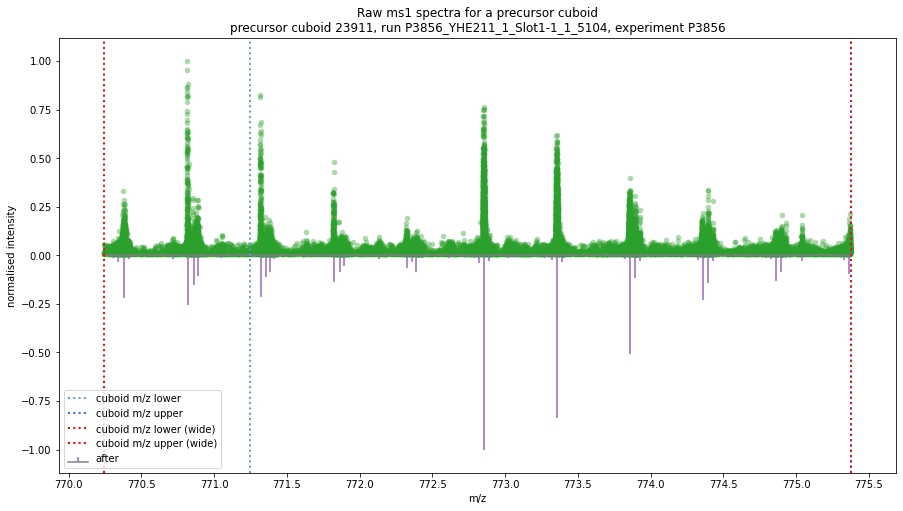

In [13]:
f, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

ax.scatter(before_df.mz, before_df.normalised_intensity, marker='o', color='tab:green', lw=0, s=30, alpha=0.4)

markerline, stemlines, baseline = ax.stem(after_df.mz, -after_df.normalised_intensity, markerfmt=" ", use_line_collection=True, label='after')
plt.setp(markerline, 'color', 'tab:purple')
plt.setp(stemlines, 'color', 'tab:purple')
plt.setp(baseline, 'color', 'tab:gray')

plt.axvline(x=metadata_d['mz_lower'], linestyle=':', color='cornflowerblue', linewidth=2, label='cuboid m/z lower')
plt.axvline(x=metadata_d['mz_upper'], linestyle=':', color='royalblue', linewidth=2, label='cuboid m/z upper')

plt.axvline(x=metadata_d['wide_mz_lower'], linestyle=':', color='red', linewidth=2, label='cuboid m/z lower (wide)')
plt.axvline(x=metadata_d['wide_mz_upper'], linestyle=':', color='red', linewidth=2, label='cuboid m/z upper (wide)')

plt.xlabel('m/z')
plt.ylabel('normalised intensity')
f.set_figheight(8)
f.set_figwidth(15)

nearest = 0.5
range_l = round(before_df.mz.min() / nearest) * nearest
range_u = round(before_df.mz.max() / nearest) * nearest
plt.xticks(np.arange(range_l,range_u+nearest,nearest))

# plt.xlim((1481,1482))

plt.margins(0.06)
plt.legend(loc='best')
plt.title('Raw ms1 spectra for a precursor cuboid\nprecursor cuboid {}, run {}, experiment {}'.format(precursor_cuboid_id, run_name, experiment_name))
plt.show()

#### zooming in on one of the isotopes

In [14]:
selected_isotope_mz_lower = 772.7
selected_isotope_mz_upper = 773

before_subset_df = before_df[(before_df.mz >= selected_isotope_mz_lower) & (before_df.mz <= selected_isotope_mz_upper)].copy()
before_subset_df.normalised_intensity = before_subset_df.intensity / before_subset_df.intensity.max()

after_subset_df = after_df[(after_df.mz >= selected_isotope_mz_lower) & (after_df.mz <= selected_isotope_mz_upper)].copy()
after_subset_df.normalised_intensity = after_subset_df.intensity / after_subset_df.intensity.max()


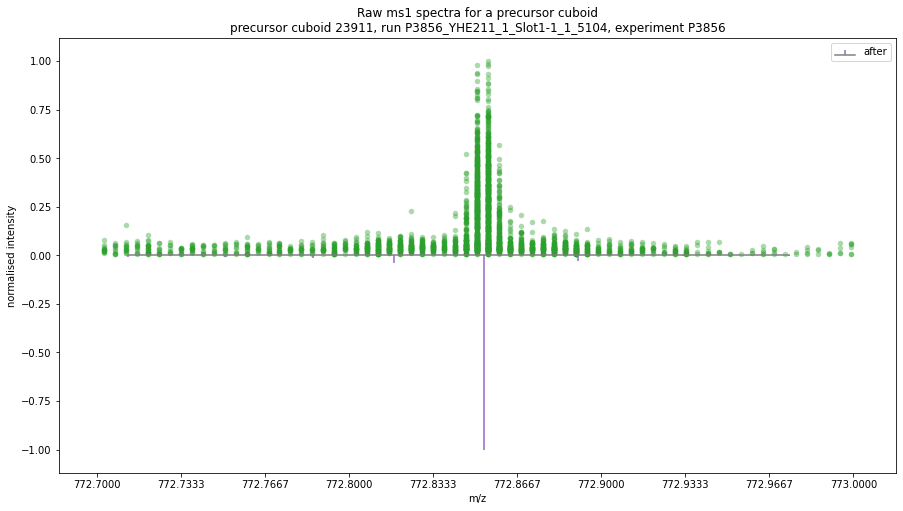

In [15]:
f, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

ax.scatter(before_subset_df.mz, before_subset_df.normalised_intensity, marker='o', color='tab:green', lw=0, s=30, alpha=0.4)

markerline, stemlines, baseline = ax.stem(after_subset_df.mz, -after_subset_df.normalised_intensity, markerfmt=" ", use_line_collection=True, label='after')
plt.setp(markerline, 'color', 'tab:purple')
plt.setp(stemlines, 'color', 'tab:purple')
plt.setp(baseline, 'color', 'tab:gray')

plt.xlabel('m/z')
plt.ylabel('normalised intensity')
f.set_figheight(8)
f.set_figwidth(15)

nearest = 0.1
range_l = round(before_subset_df.mz.min() / nearest) * nearest
range_u = round(before_subset_df.mz.max() / nearest) * nearest

ax.set_xticks(np.linspace(range_l, range_u, num=10, endpoint=True))
ax.ticklabel_format(useOffset=False)

plt.margins(0.06)
plt.legend(loc='best')
plt.title('Raw ms1 spectra for a precursor cuboid\nprecursor cuboid {}, run {}, experiment {}'.format(precursor_cuboid_id, run_name, experiment_name))
plt.show()

#### plot the features after deconvolution

In [16]:
features_df = vis_d['deconvolution_features_df']

In [17]:
# find the maximum envelope intensity for normalisation
max_envelope_intensity = 0
for idx,row in enumerate(features_df.itertuples()):
    envelope_df = pd.DataFrame(row.envelope, columns=['mz','intensity'])
    max_envelope_intensity = max(max_envelope_intensity,envelope_df.intensity.max())
max_envelope_intensity

620774.0

In [18]:
features_df.columns

Index(['mono_mz', 'second_peak_mz', 'intensity', 'score', 'SN', 'charge',
       'envelope', 'neutral_mass'],
      dtype='object')

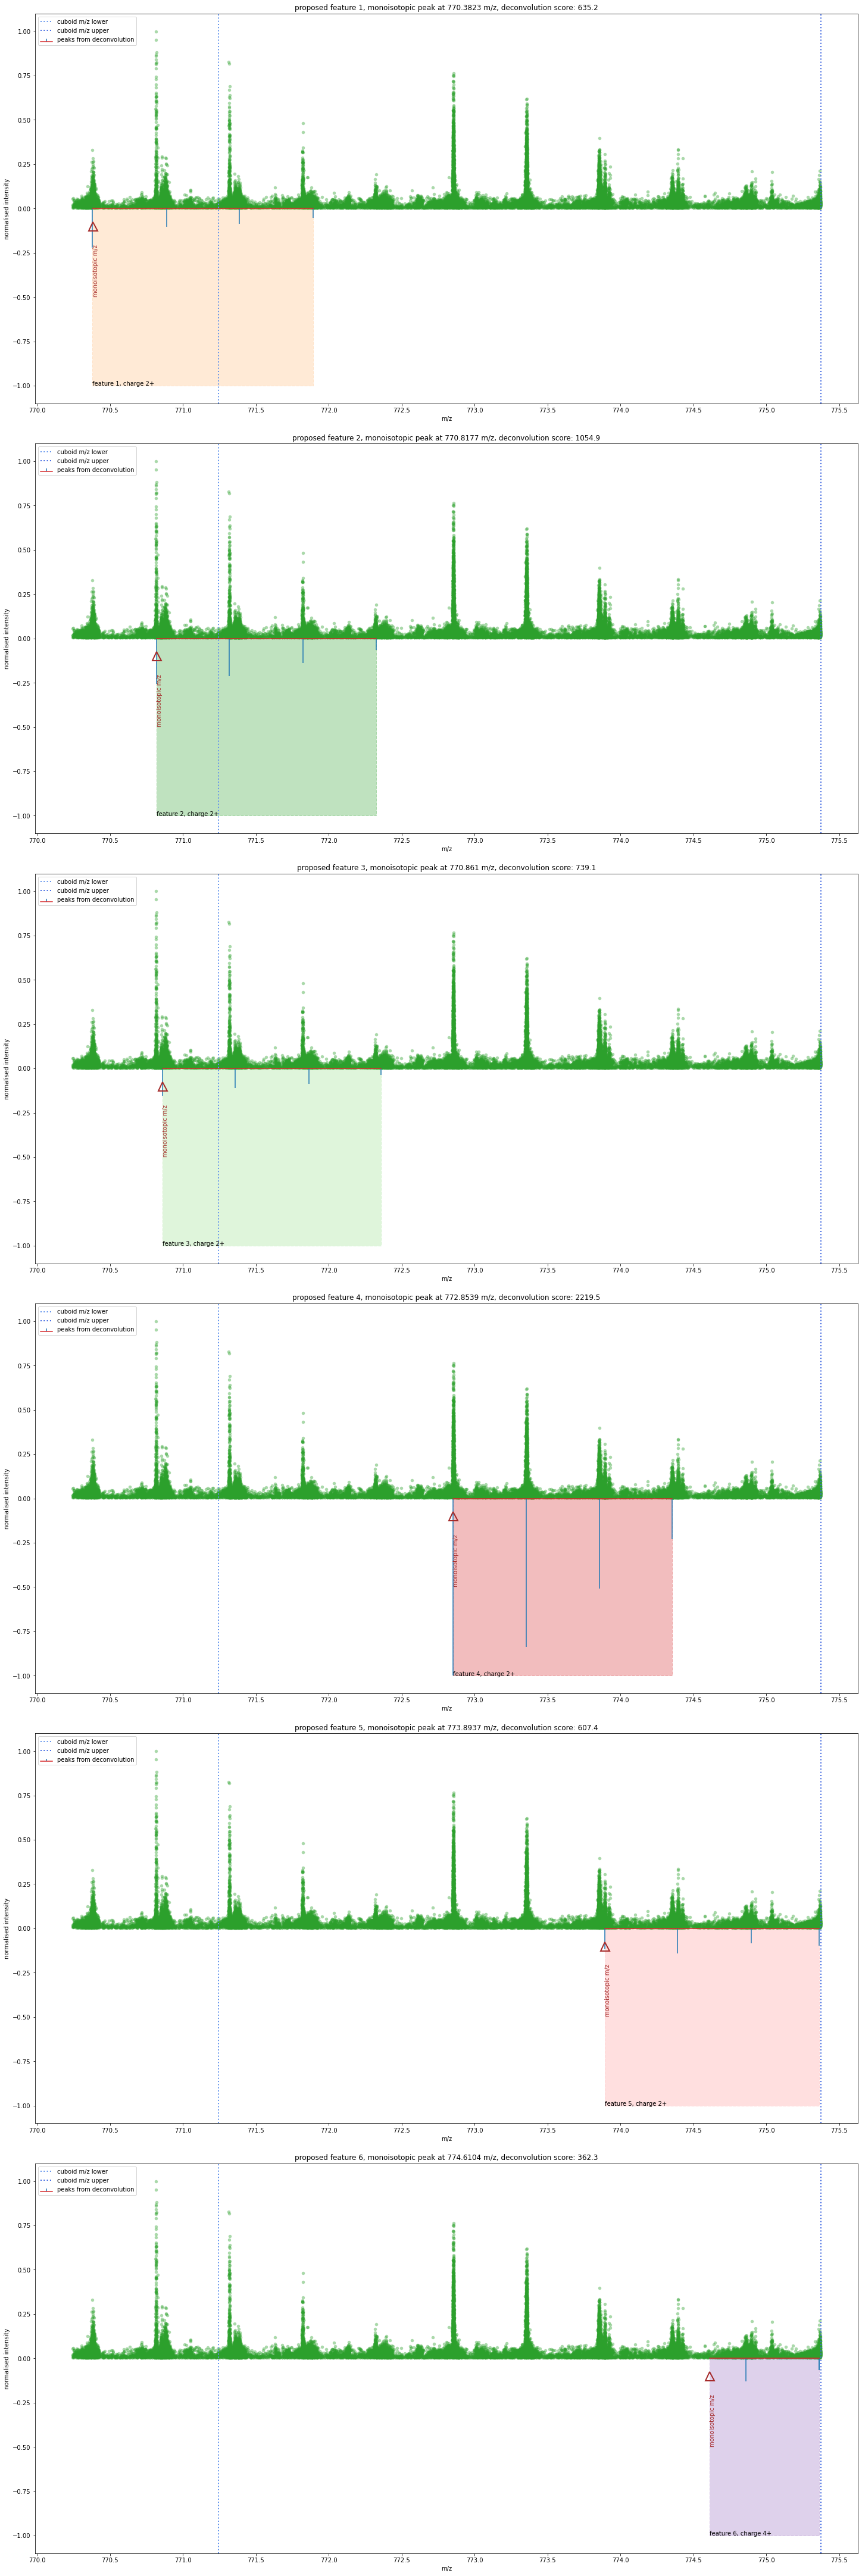

In [20]:
f, axarr = plt.subplots(nrows=len(features_df), ncols=1, constrained_layout=True)
# f.suptitle('isotopic peaks of features from deconvolution\n', fontsize=18)

f.set_figheight(len(features_df)*10)
f.set_figwidth(20)

# plot the features derived from deconvoluting the peaks
for idx,row in enumerate(features_df.itertuples()):
    if len(features_df) > 1:
        ax = axarr[idx]  # row, column
    else:
        ax = axarr

    # plot the raw data
    ax.scatter(before_df.mz, before_df.normalised_intensity, marker='o', color='tab:green', lw=0, s=30, alpha=0.4)

    # plot the feature's bounding rectangle
    envelope = row.envelope
    feature_id = idx+1
    env_width = envelope[-1][0] - envelope[0][0]
    rect_colour = tableau20_mpl[idx+3]
    rect = patches.Rectangle((envelope[0][0],0),env_width,-1.0,linewidth=1,linestyle=(0,(5,2)),edgecolor=rect_colour+(0.3,),facecolor=rect_colour+(0.3,),fill=True)
    ax.add_patch(rect)
    ax.text(x=envelope[0][0], y=-1.0, s='feature {}, charge {}+'.format(feature_id, row.charge))

    # determine the peaks from the envelope
    envelope_df = pd.DataFrame(envelope, columns=['mz','intensity'])
    envelope_df['normalised_intensity'] = envelope_df.intensity / max_envelope_intensity

    # plot the peaks from deconvolution
    markerline, stemlines, baseline = ax.stem(envelope_df.mz, -envelope_df.normalised_intensity, markerfmt=" ", use_line_collection=True, label='peaks from deconvolution')
    
    # show the monoisotopic m/z determined by deconvolution
    ax.plot(row.mono_mz, -0.1, marker='^', markerfacecolor='none', markeredgecolor='brown', linestyle='', markeredgewidth=2, ms=15)
    text_style = dict(size=10, color='brown', verticalalignment='center', horizontalalignment='left')
    ax.text(row.mono_mz, -0.35, "monoisotopic m/z", **text_style, rotation='vertical')

    ax.axvline(x=metadata_d['mz_lower'], linestyle=':', color='cornflowerblue', linewidth=2, label='cuboid m/z lower')
    ax.axvline(x=metadata_d['mz_upper'], linestyle=':', color='royalblue', linewidth=2, label='cuboid m/z upper')

    nearest = 0.5
    range_l = round(before_df.mz.min() / nearest) * nearest
    range_u = round(before_df.mz.max() / nearest) * nearest
    ax.set_xticks(np.arange(range_l,range_u+nearest,nearest))

    ax.set_xlabel('m/z')
    ax.set_ylabel('normalised intensity')
    ax.legend(loc='best')
    
    ax.set_title('proposed feature {}, monoisotopic peak at {} m/z, deconvolution score: {}'.format(feature_id, round(row.mono_mz,4), round(row.score,1)))

plt.show()

#### let's zoom in on the monoisotopic peak

In [21]:
features_df = vis_d['features_df']

In [22]:
features_df.columns

Index(['monoisotopic_mz', 'charge', 'monoisotopic_mass', 'feature_intensity',
       'envelope_mono_peak_mz', 'envelope_mono_peak_intensity', 'envelope',
       'isotope_count', 'deconvolution_score', 'mz_apex', 'mz_lower',
       'mz_upper', 'mono_mz_without_saturated_points', 'scan_apex',
       'scan_lower', 'scan_upper', 'rt_apex', 'rt_lower', 'rt_upper',
       'mono_intensity_from_raw_points', 'mono_intensity_adjustment_outcome',
       'isotopic_peaks', 'scan_df', 'rt_df', 'precursor_cuboid_id',
       'fragment_ions_l', 'feature_id'],
      dtype='object')

In [23]:
# selecting a feature to look at more closely
proposed_feature_number = 2
feature = features_df.iloc[proposed_feature_number-1]

In [24]:
isotopes_l = feature.isotopic_peaks
monoisotopic = isotopes_l[0]
monoisotopic

{'mz': 770.817701637742,
 'mz_lower': 770.7931514268456,
 'mz_upper': 770.8422518486383,
 'intensity': 134909,
 'saturated': False,
 'inferred_intensity': 134909,
 'inferred': False}

In [25]:
raw_points_df = vis_d['wide_ms1_points_df']
scan_lower = feature['scan_lower']
scan_upper = feature['scan_upper']
rt_lower = feature['rt_lower']
rt_upper = feature['rt_upper']
mono_mz = monoisotopic['mz']
mono_mz_lower = monoisotopic['mz_lower']
mono_mz_upper = monoisotopic['mz_upper']

In [26]:
mono_points_df = raw_points_df[(raw_points_df.scan >= scan_lower) & (raw_points_df.scan <= scan_upper) & (raw_points_df.retention_time_secs >= rt_lower) & (raw_points_df.retention_time_secs <= rt_upper) & (raw_points_df.mz >= mono_mz_lower) & (raw_points_df.mz <= mono_mz_upper)]
len(mono_points_df)

465

In [27]:
background_mz_delta = 0.5
background_points_df = raw_points_df[(raw_points_df.scan >= scan_lower) & (raw_points_df.scan <= scan_upper) & (raw_points_df.retention_time_secs >= rt_lower) & (raw_points_df.retention_time_secs <= rt_upper) & (raw_points_df.mz >= mono_mz_lower-background_mz_delta) & (raw_points_df.mz <= mono_mz_upper+background_mz_delta)]


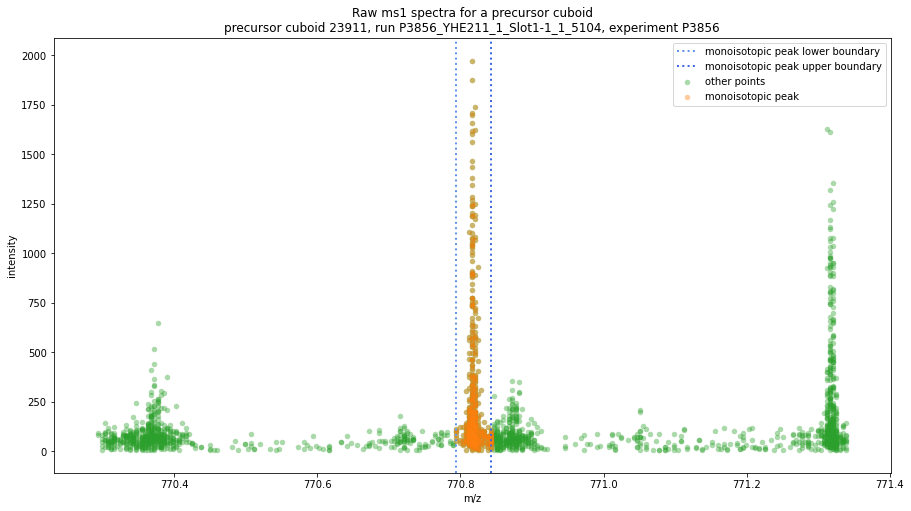

In [28]:
f, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

ax.scatter(background_points_df.mz, background_points_df.intensity, marker='o', color='tab:green', lw=0, s=30, alpha=0.4, label='other points')
ax.scatter(mono_points_df.mz, mono_points_df.intensity, marker='o', color='tab:orange', lw=0, s=30, alpha=0.4, label='monoisotopic peak')

plt.xlabel('m/z')
plt.ylabel('intensity')
f.set_figheight(8)
f.set_figwidth(15)

ax.axvline(x=mono_mz_lower, linestyle=':', color='cornflowerblue', linewidth=2, label='monoisotopic peak lower boundary')
ax.axvline(x=mono_mz_upper, linestyle=':', color='royalblue', linewidth=2, label='monoisotopic peak upper boundary')

plt.margins(0.06)
plt.legend(loc='best')
plt.title('Raw ms1 spectra for a precursor cuboid\nprecursor cuboid {}, run {}, experiment {}'.format(precursor_cuboid_id, run_name, experiment_name))
plt.show()

In [29]:
feature

monoisotopic_mz                                                                770.818
charge                                                                               2
monoisotopic_mass                                                              1539.62
feature_intensity                                                               418343
envelope_mono_peak_mz                                                          770.818
envelope_mono_peak_intensity                                                    159390
envelope                             [[770.817701637742, 159390.0], [771.3183732111...
isotope_count                                                                        4
deconvolution_score                                                            1054.94
mz_apex                                                                        770.818
mz_lower                                                                         772.3
mz_upper                                   

In [30]:
scan_df = pd.DataFrame(feature.scan_df)

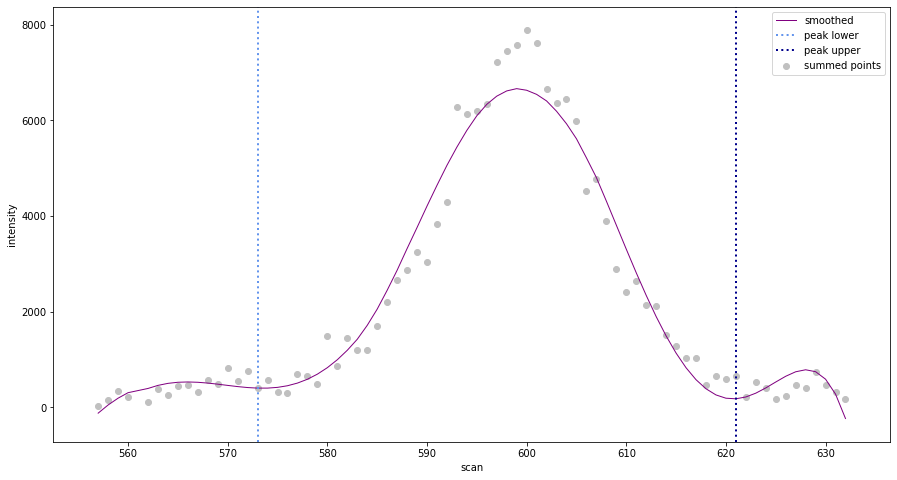

In [43]:
f, ax = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)

plt.scatter(scan_df.scan, scan_df.intensity, c='silver', label='summed points')

# plot the filtered curve
ax.plot(scan_df.scan, scan_df.filtered_intensity, marker='', color='purple', linestyle='-', linewidth=1, ms=5, label='smoothed')

ax.axvline(x=feature.scan_lower, linestyle=':', color='cornflowerblue', linewidth=2, label='peak lower')
ax.axvline(x=feature.scan_upper, linestyle=':', color='darkblue', linewidth=2, label='peak upper')

# plt.ylim(bottom=0)

ax.legend(loc='best')

plt.xlabel("scan")
plt.ylabel("intensity")
plt.show()

In [32]:
rt_df = pd.DataFrame(feature.rt_df)

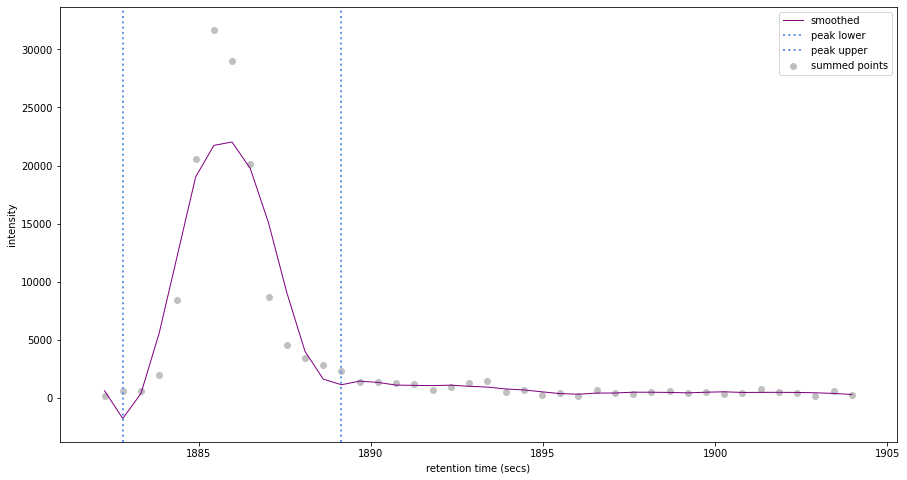

In [45]:
f, ax = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)

plt.scatter(rt_df.retention_time_secs, rt_df.intensity, c='silver', label='summed points')

# plot the fitted curve
ax.plot(rt_df.retention_time_secs, rt_df.filtered_intensity, marker='', color='purple', linestyle='-', linewidth=1, ms=5, label='smoothed')

ax.axvline(x=feature.rt_lower, linestyle=':', color='cornflowerblue', linewidth=2, label='peak lower')
ax.axvline(x=feature.rt_upper, linestyle=':', color='cornflowerblue', linewidth=2, label='peak upper')

ax.legend(loc='best')

plt.xlabel("retention time (secs)")
plt.ylabel("intensity")
plt.show()

#### how gaussian is this peak in the m/z dimension?

In [34]:
# calculate the r-squared value of series_2 against series_1, where series_1 is the original data (source: https://stackoverflow.com/a/37899817/1184799)
def calculate_r_squared(series_1, series_2):
    residuals = series_1 - series_2
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((series_1 - np.mean(series_1))**2)
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared

In [35]:
mono_points_df = mono_points_df.copy()
mono_points_df['normalised_intensity'] = mono_points_df.intensity / mono_points_df.intensity.max()

In [36]:
mono_points_df['mz_rounded'] = mono_points_df.apply(lambda row: round(row.mz,4), axis=1)

In [37]:
mono_attributes_l = []
for group_name,group_df in mono_points_df.groupby(['mz_rounded'], as_index=False):
    mono_attributes_l.append({'mz':group_name, 'max_intensity':group_df.intensity.max(), 'median_intensity':group_df.intensity.median(), 'mean_intensity':group_df.intensity.mean()})
mono_attributes_df = pd.DataFrame(mono_attributes_l)
mono_attributes_df['normalised_max_intensity'] = mono_attributes_df.max_intensity / mono_attributes_df.max_intensity.max()


In [38]:
guassian_params = peakutils.peak.gaussian_fit(mono_attributes_df.mz, mono_attributes_df.normalised_max_intensity, center_only=False)
fitted_curve_x = np.linspace(mono_mz_lower, mono_mz_upper, num=200)
fitted_curve_y = peakutils.peak.gaussian(fitted_curve_x, guassian_params[0], guassian_params[1], guassian_params[2])

In [39]:
# put the fitted curve on the same x-values so we can calculate the R-squared
fitted_intensities = peakutils.peak.gaussian(mono_attributes_df.mz.to_numpy(), guassian_params[0], guassian_params[1], guassian_params[2])

# calculate the R-squared of the fit against the observed
r_squared = calculate_r_squared(fitted_intensities, mono_attributes_df.normalised_max_intensity.to_numpy())

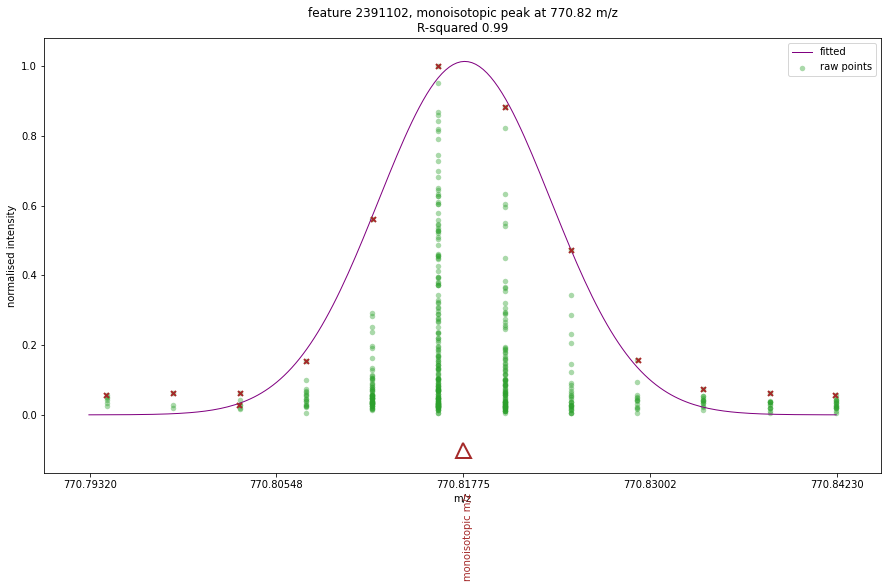

In [47]:
f, ax = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)

# plot the raw data
ax.scatter(mono_points_df.mz, mono_points_df.normalised_intensity, marker='o', color='tab:green', lw=0, s=30, alpha=0.4, label='raw points')

# plot the fitted curve
ax.plot(fitted_curve_x, fitted_curve_y, marker='', color='purple', linestyle='-', linewidth=1, ms=5, label='fitted')

# show the monoisotopic m/z determined by deconvolution
ax.plot(mono_mz, -0.1, marker='^', markerfacecolor='none', markeredgecolor='brown', linestyle='', markeredgewidth=2, ms=15)
text_style = dict(size=10, color='brown', verticalalignment='center', horizontalalignment='left')
ax.text(mono_mz, -0.35, "monoisotopic m/z", **text_style, rotation='vertical')

# plot the markers to which we fit the curve
ax.plot(mono_attributes_df.mz, mono_attributes_df.normalised_max_intensity, marker='x', markerfacecolor='none', markeredgecolor='brown', linestyle='', markeredgewidth=2, ms=5)

# set up the tick marks
nearest = 0.0001
range_l = round(mono_mz_lower / nearest) * nearest
range_u = round(mono_mz_upper / nearest) * nearest
ax.set_xticks(np.linspace(range_l, range_u, num=5, endpoint=True))
ax.ticklabel_format(useOffset=False)

ax.set_xlabel('m/z')
ax.set_ylabel('normalised intensity')
ax.legend(loc='best')

# ax.set_ylim((-1.1,1.1))
ax.set_title('feature {}, monoisotopic peak at {} m/z\nR-squared {}'.format(feature.feature_id, round(mono_mz,2), round(r_squared, 2)))
plt.show()